## Welcome to Plotbot!

👋 Welcome to Plotbot! A your class-oriented workflow optimizer for downloading and plotting data from the Parker Solar Probe. Created by Dr. Jaye Verniero and Dr. Robert Alexander. Note: this is a work in progress.

⚡️Plotbot utilizes active calculation caching⚡️
   ⚡️Calculate once and forget about it⚡️

First, click in the upper right hand corner of this window to select the plotbot environment. It should be named plotbot_env (Python 3.12.4). Alternatively, you'll be prompted to select the environment when you run the first cell below.







### Plotbot

Let's get started by importing plotbot:

In [1]:
#Remember to select the Plotbot Environment!
#A new import style to discuss:
# import plotbot
from plotbot import *

initialized server_access
initialized global_tracker
initialized ploptions
initialized plot_manager
initialized epad class
initialized epad_hr class
initialized proton class
initialized proton_hr class
initialized ham_class
initialized psp_alpha class
initialized psp_qtn class
initialized data_cubby.
initialized proton_fits class
🔉 initialized audifier

Importing libraries, this may take a moment. Hold tight... 

✅ Imported standard libraries and utilities.
✅ Imported numpy, pandas, and scipy libraries.
✅ Imported matplotlib libraries.
✅ Imported cdflib, BeautifulSoup, requests, dateutil, and datetime libraries.

🤖 Plotbot Initialized
✨ Showdahodo initialized
Positional Data Helper Initialized
📈📉 Multiplot Initialized
   Version: 2025_06_30_v2.74
   Commit: v2.74 BREAKTHROUGH: PSP QTN class implementation - most reliable electron density measurements

🤖 Plotbot Initialized


#### ✨ The Data Snapshot! Save All Current Calculations to .pkl✨

In [2]:
# #Uncomment to explore the data snapshot!

# #Never wait for calculations again!
# #At the end of your session, save your cache'd calculations to a .pkl file:
# save_simple_snapshot('my_calculated_data.pkl') 

# # Load the cache at the beginning of your next session like this: 
# load_simple_snapshot('my_calculated_data.pkl') 

# # And the best part? Any new calculations will automatically be
# # merged with your import, and you can just save again at the
# # end of your next session!

#### ✨Diving In✨

In [3]:
print_manager.show_status = True
print_manager.show_debug = False
print_manager.show_processing = False
print_manager.show_data_cubby = False
print_manager.show_time_tracking = False

In [4]:
# config.data_server = 'berkeley'
config.data_server = 'spdf'
# config.data_server = 'dynamic'  #<--default to SPDF with Berkeley as a secondary choice

🤖 Plotbot starting...
🛰️ mag_SC_4sa - acquiring variables: bx
 
📥 Acquiring data for 1 regular variables...
🛰️ mag_SC_4sa - acquiring variables: bx
Attempting Berkeley acquisition path for mag_SC_4sa...
📡 mag_SC_4sa - A local .cdf file already exists:
📂 data/psp/fields/l2/mag_sc_4_per_cycle/2021/psp_fld_l2_mag_SC_4_Sa_per_Cyc_20210426_v02.cdf
☑️ - CDF Data import complete for mag_SC_4sa range ['2021/04/26 00:00:00', '2021/04/27 00:00:00'].

📥 Requesting DataCubby to update/merge global instance for mag_sc_4sa...
✅ DataCubby processed update for mag_sc_4sa.
✅ Complete
📈 Plotting mag_sc_4sa.bx


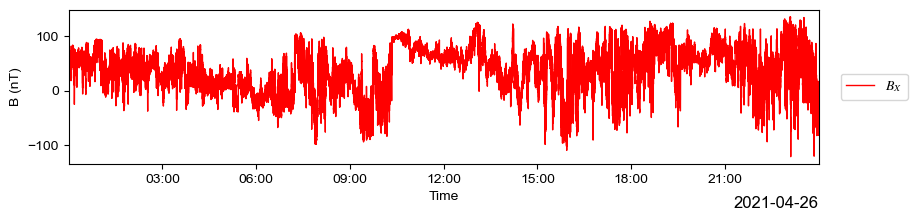

In [5]:
plt.options.reset()
#----Print manager----/// ✨ Two levels of print manager verbosity
print_manager.show_status = True
print_manager.show_debug = False
print_manager.show_processing = False
print_manager.show_data_cubby = False

#an example for how to use the pb.config to change the data server setting
config.data_server = 'berkeley' #<--default to SPDF with Berkeley as a secondary choice
# Server options are 'default', 'spdf' or 'berkeley'
# pb.print_manager.show_debug = True
# pb.print_manager.show_processing = True
# pb.print_manager.show_data_cubby = True

plt.options.use_single_title = True

# test_trange = ['2022/03/26 00:00:00.000', '2022/03/26 23:59:59.999']
test_trange = ['2021/04/26 00:00:00.000', '2021/04/27 00:00:00.000']

Trange_1 = ['2021/04/26 00:00:00.000', '2021/04/27 00:00:00.000']
# Trange_2 = ['2022/05/26 00:00:00.000', '2022/05/27 00:00:00.000']
# plotbot(Trange_1, mag_rtn_4sa.br, 1)
# plotbot(Trange_2, mag_rtn_4sa.br, 1)
# plotbot(Trange_1, mag_rtn.br_norm, 1, mag_rtn_4sa.br_norm, 2)
# plotbot(Trange_1, mag_rtn_4sa.br, 1, mag_rtn_4sa.br_norm, 2)
# plotbot(Trange_1, proton_hr.energy_flux, 1, mag_rtn_4sa.br_norm, 2)
# plotbot(Trange_1, mag_rtn.br_norm, 1, mag_rtn_4sa.br_norm, 2)

# plotbot(test_trange, mag_rtn.br, 1)
plotbot(test_trange, mag_sc_4sa.bx, 1)

# plotbot(Trange_1, proton.anisotropy, 1)
# plotbot(Trange_2, proton.anisotropy, 1)

🤖 Plotbot starting...
🛰️ mag_RTN_4sa - acquiring variables: br
🛰️ spe_sf0_pad - acquiring variables: strahl
 
📥 Acquiring data for 2 regular variables...
🛰️ mag_RTN_4sa - acquiring variables: br
🛰️ spe_sf0_pad - acquiring variables: strahl
mag_rtn_4sa already calculated for the time range: 2018-10-22 12:00:00 to 2018-10-27 13:00:00
📤 Using existing mag_rtn_4sa data, calculation/import not needed.
epad already calculated for the time range: 2018-10-22 12:00:00 to 2018-10-27 13:00:00
📤 Using existing epad data, calculation/import not needed.
✅ Complete
📈 Plotting mag_rtn_4sa.br
📈 Plotting epad.strahl


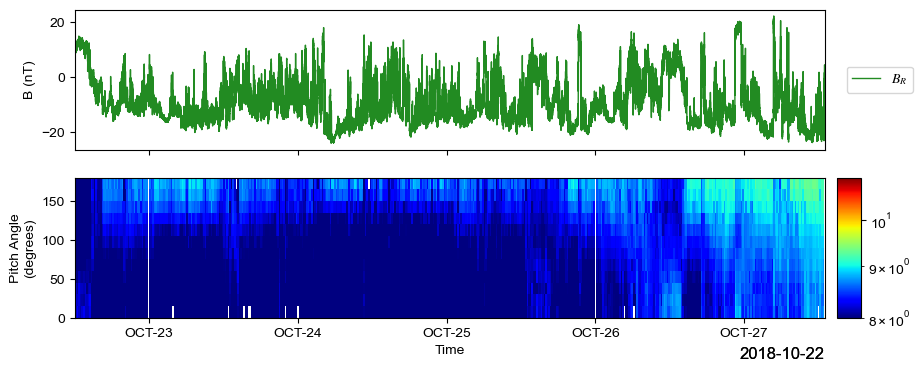

In [13]:
#Enable widget for interactive plots! The panel on the left provides different interaction modes:

# %matplotlib widget
%matplotlib inline 

#--------//

trange = ['2018-10-22 12:00:00', '2018-10-27 13:00:00']

epad.strahl.colorbar_limits = [8, 11]
epad.strahl.colorbar_scale = 'log'



plotbot(trange, mag_rtn_4sa.br, 1, epad.strahl, 2)

In [7]:
# # A test for consecutive time ranges...
# plt.options.reset()
# #----Print manager----/// ✨ Two levels of print manager verbosity
# print_manager.show_status = True
# print_manager.show_debug = True
# print_manager.show_processing = True
# print_manager.show_data_cubby = True
# print_manager.show_warning = True

# #an example for how to use the pb.config to change the data server setting
# config.data_server = 'berkeley' #<--default to SPDF with Berkeley as a secondary choice
# # Server options are 'default', 'spdf' or 'berkeley'
# # pb.print_manager.show_debug = True
# # pb.print_manager.show_processing = True
# # pb.print_manager.show_data_cubby = True

# # plt.options.use_single_title = True

# Trange_1 = ['2021/04/26 00:00:00.000', '2021/04/28 00:00:00.000']
# Trange_2 = ['2021/04/28 00:00:00.000', '2021/05/2 00:00:00.000']
# plotbot(Trange_1, proton_hr.energy_flux, 1)
# # plotbot(Trange_2, proton_hr.energy_flux, 1)

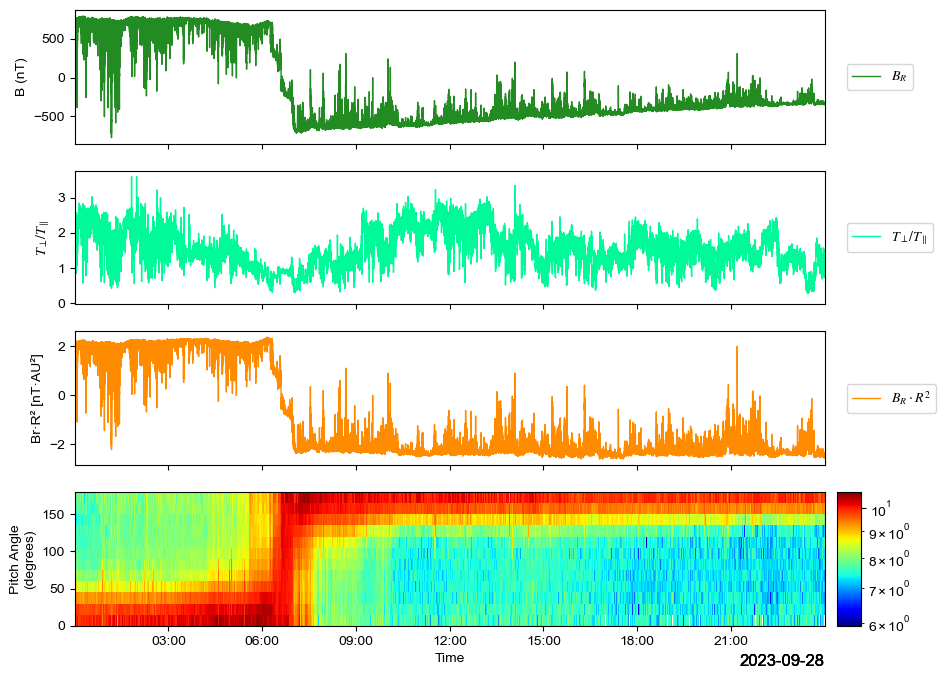

In [8]:
print_manager.show_status = False
TRANGE = ['2023-09-28/00:00:00.000', '2023-09-29/00:00:00.000'] # 1 day
plotbot(TRANGE, mag_rtn_4sa.br, 1, proton.anisotropy, 2, mag_rtn_4sa.br_norm, 3, epad.strahl, 4)
# plotbot(TRANGE, mag_rtn.br, 1, proton.anisotropy, 2, mag_rtn.br_norm, 3, epad.strahl, 4)

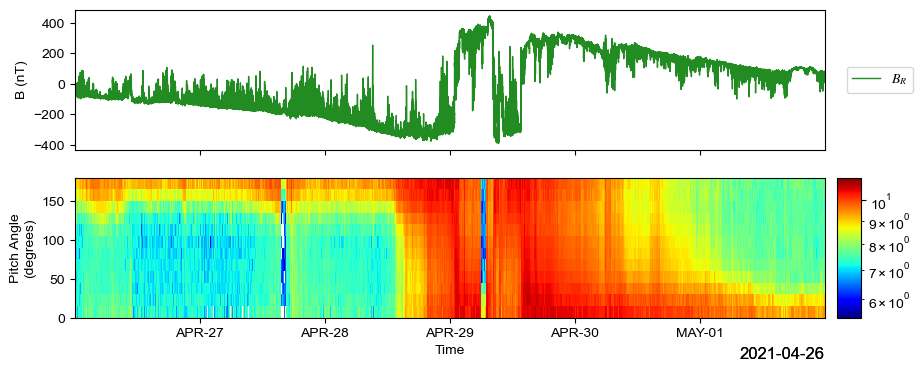

In [9]:
plt.options.reset()
#----Print manager----/// ✨ Two levels of print manager verbosity
print_manager.show_status = False
print_manager.show_debug = False

#an example for how to use the pb.config to change the data server setting
config.data_server = 'berkeley' #<--default to SPDF with Berkeley as a secondary choice
# Server options are 'default', 'spdf' or 'berkeley'

print_manager.show_status = False
# pb.print_manager.show_debug = True
# pb.print_manager.show_processing = True
# pb.print_manager.show_data_cubby = True

plt.options.use_single_title = True

Jaye_epad_trange = ['2021/04/26 00:00:00.000', '2021/05/2 00:00:00.000']
plotbot(Jaye_epad_trange, mag_rtn_4sa.br, 1, epad.strahl, 2)

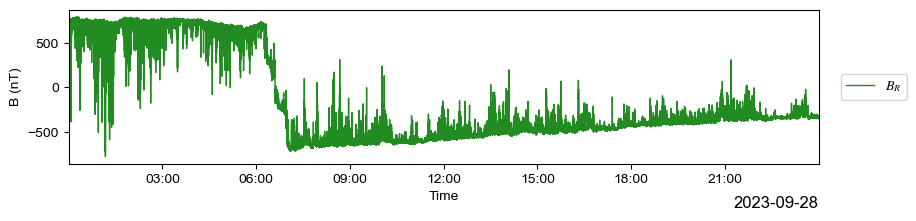

In [10]:
TRANGE = ['2023-09-28/00:00:00.000', '2023-09-29/00:00:00.000'] # 1 day
plotbot(TRANGE, mag_rtn_4sa.br, 1)

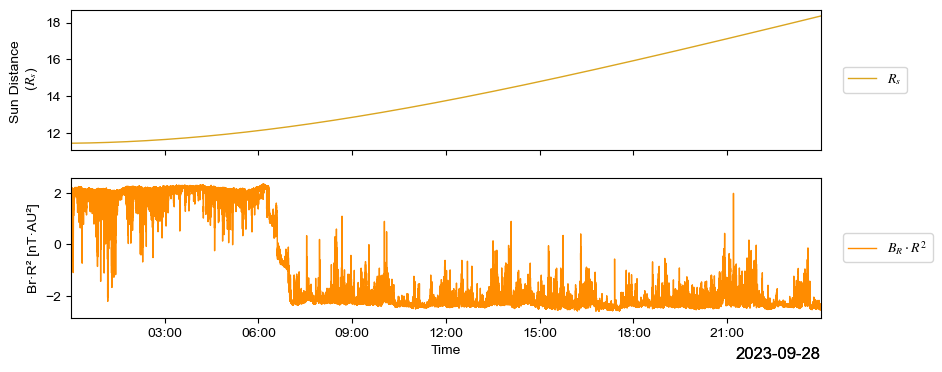

In [11]:
# print_manager.show_status = True
TRANGE = ['2023-09-28/00:00:00.000', '2023-09-29/00:00:00.000'] # 1 day
# plotbot(TRANGE, mag_rtn_4sa.br, 1, proton.sun_dist_rsun, 2, mag_rtn_4sa.br_norm, 3, epad.strahl, 4)
plotbot(TRANGE, proton.sun_dist_rsun, 1, mag_rtn_4sa.br_norm, 2)

In [12]:
print_manager.show_status = True
print_manager.show_debug = False
trange = ['2025-03-19 00:00:00.000', '2025-03-27 23:59:59.000']
plotbot(trange,
        ham.hamogram_30s, 1,
        proton.m_alfven, 2,
        proton.density,3,
        proton.bmag,4,
        proton.sun_dist_rsun, 5)

🤖 Plotbot starting...
🛰️ spi_sf00_l3_mom - acquiring variables: m_alfven, density, bmag, sun_dist_rsun
🛰️ ham - acquiring variables: hamogram_30s
 
📥 Acquiring data for 5 regular variables...
🛰️ spi_sf00_l3_mom - acquiring variables: m_alfven, density, bmag, sun_dist_rsun
🛰️ ham - acquiring variables: hamogram_30s
Attempting Berkeley acquisition path for spi_sf00_l3_mom...
📡 spi_sf00_l3_mom - Local .cdf files already exist:
📂 data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_L3_mom_20250319_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_L3_mom_20250320_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_L3_mom_20250321_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_L3_mom_20250322_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_L3_mom_20250323_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_L3_mom_20250324_v00.cdf, data/psp/sweap/spi/l3/spi_sf00_l3_mom/2025/psp_swp_spi_sf00_

KeyboardInterrupt: 

🤖 Plotbot starting...
🛰️ proton_fits - acquiring variables: abs_qz_p, vdrift_va_pfits, valfven_pfits, beta_ppar_pfits, beta_pperp_pfits
 
📥 Acquiring data for 5 regular variables...
🛰️ proton_fits - calculation may be needed
✅ - FITS raw data import complete for range ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000'].

📥 Updating proton_fits with calculated data...
☑️ - CDF Data import complete for spi_sf00_l3_mom range ['2024-09-30/00:00:01.536000', '2024-09-30/23:59:54.893000'].

✅ Complete
📈 Plotting proton_fits.abs_qz_p
📈 Plotting proton_fits.vdrift_va_pfits
📈 Plotting proton_fits.valfven_pfits
📈 Plotting proton_fits.beta_ppar_pfits
📈 Plotting proton_fits.beta_pperp_pfits


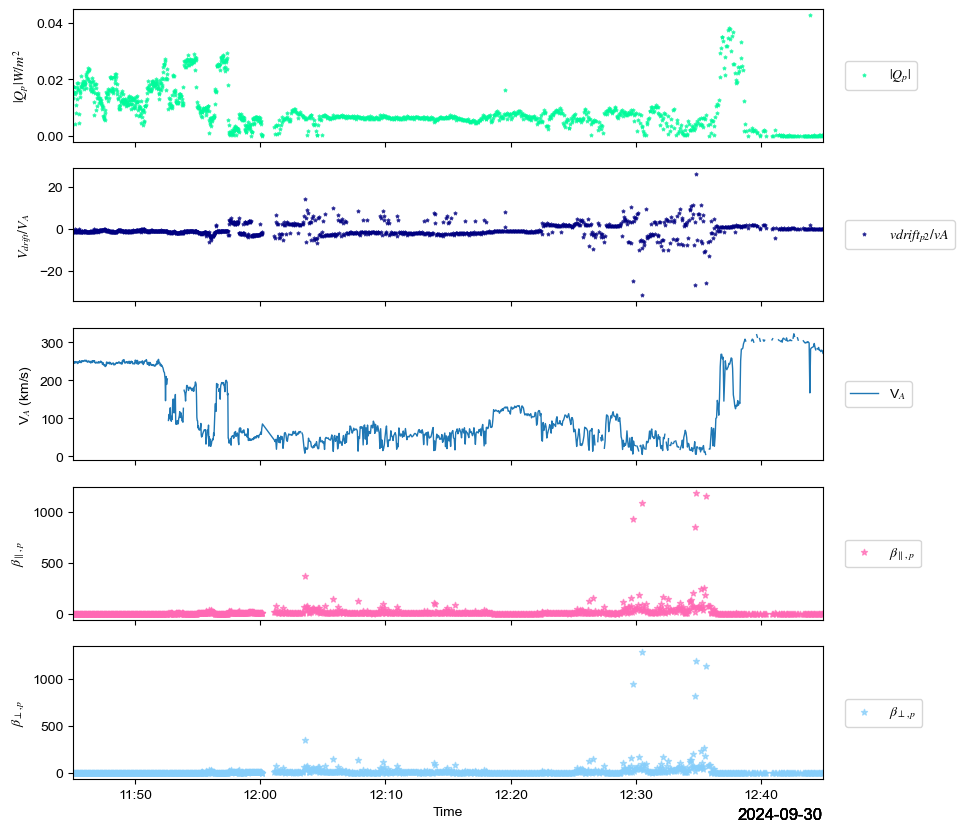

In [17]:
## Example of new proton fits naming convention!

print_manager.show_data_snapshot = False
print_manager.show_status = True
fits_trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

# pb.data_snapshot.load_data_snapshot('project_data.pkl')

plotbot(fits_trange, proton_fits.abs_qz_p, 1, proton_fits.vdrift_va_pfits, 2, proton_fits.valfven_pfits, 3, proton_fits.beta_ppar_pfits, 4, proton_fits.beta_pperp_pfits, 5)


In [18]:
# # ✨ Using the original import style for the remainder of the notebook 
# import plotbot
# from plotbot import *

In [19]:
# For Testing IDE Auto Completion
# epad.strahl.legend_label
# epad_hr.strahl.legend_label
# proton.energy_flux.legend_label
# proton_hr.energy_flux.legend_label
# mag_rtn.br.legend_label
# mag_rtn_4sa.br.legend_label
# mag_sc.bx.legend_label
# mag_sc_4sa.bx.legend_label
# proton_fits.np1.legend_label
# ham.ham_core_drift.colorbar_label

In [20]:
config.data_server = 'dynamic' # Berkeley is generally the faster way to go!

In [21]:
#----Print manager----/// ✨ All the available print manager options 

print_manager.show_status = False  # Status prints ⭐️ useful for basic status updates

print_manager.show_debug = False  # Debug prints, helpful for debugging (will print a LOT of information)

print_manager.pyspedas_verbose = False

print_manager.show_processing = False # e.g. Processing mag_RTN_4sa...

print_manager.show_custom_debug = False  # Custom variable operations debugging

print_manager.show_time_tracking = False  # For tracking datetime array inputs and outputs
print_manager.show_warning = False     # Turn off warning messages
print_manager.show_variable_testing = False
print_manager.show_test = False  # Turn off test-specific output

print_manager.show_module_prefix = False  # Show/Hide [print_manager]
print_manager.show_category_prefix = False  # Show/Hide [PROCESS], [TIME], etc.

## Proton Fits! (Local CSV required)

🤖 Plotbot starting...
🛰️ proton_fits - acquiring variables: abs_qz_p, vdrift_va_pfits, valfven_pfits, beta_ppar_pfits, beta_pperp_pfits
 
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
✅ All data already cached for 5 regular variables in the specified trange.
📈 Plotting proton_fits.abs_qz_p
📈 Plotting proton_fits.vdrift_va_pfits
📈 Plotting proton_fits.valfven_pfits
📈 Plotting proton_fits.beta_ppar_pfits
📈 Plotting proton_fits.beta_pperp_pfits


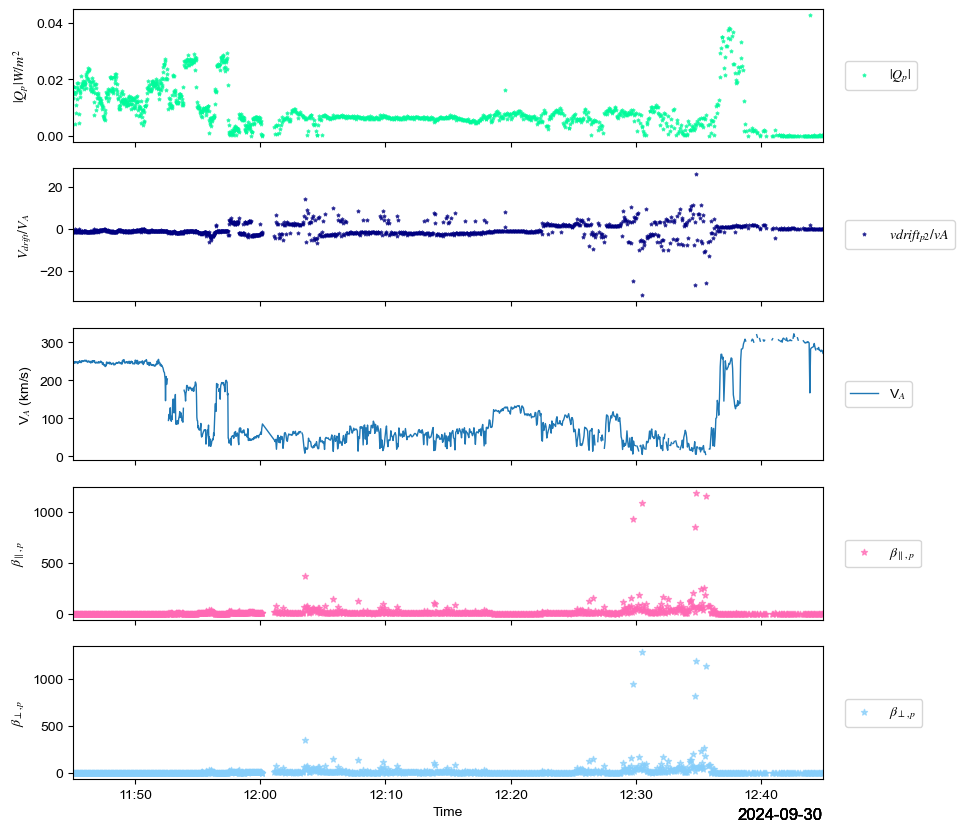

In [22]:
## Example of new proton fits naming convention!

print_manager.show_status = True
fits_trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

# data_snapshot.save_data_snapshot('project_data.pkl')

plotbot(fits_trange, proton_fits.abs_qz_p, 1, proton_fits.vdrift_va_pfits, 2, proton_fits.valfven_pfits, 3, proton_fits.beta_ppar_pfits, 4, proton_fits.beta_pperp_pfits, 5)


## Generate Plots from HAM Files (Local CSV required)

🤖 Plotbot starting...
🛰️ proton_fits - acquiring variables: np1, ham_param, Tperp1, vdrift_va_pfits
 
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
proton_fits already calculated for the time range: 2024-09-30/11:45:00.000 to 2024-09-30/12:45:00.000
✅ All data already cached for 4 regular variables in the specified trange.
📈 Plotting proton_fits.np1
📈 Plotting proton_fits.ham_param
📈 Plotting proton_fits.Tperp1
📈 Plotting proton_fits.vdrift_va_pfits


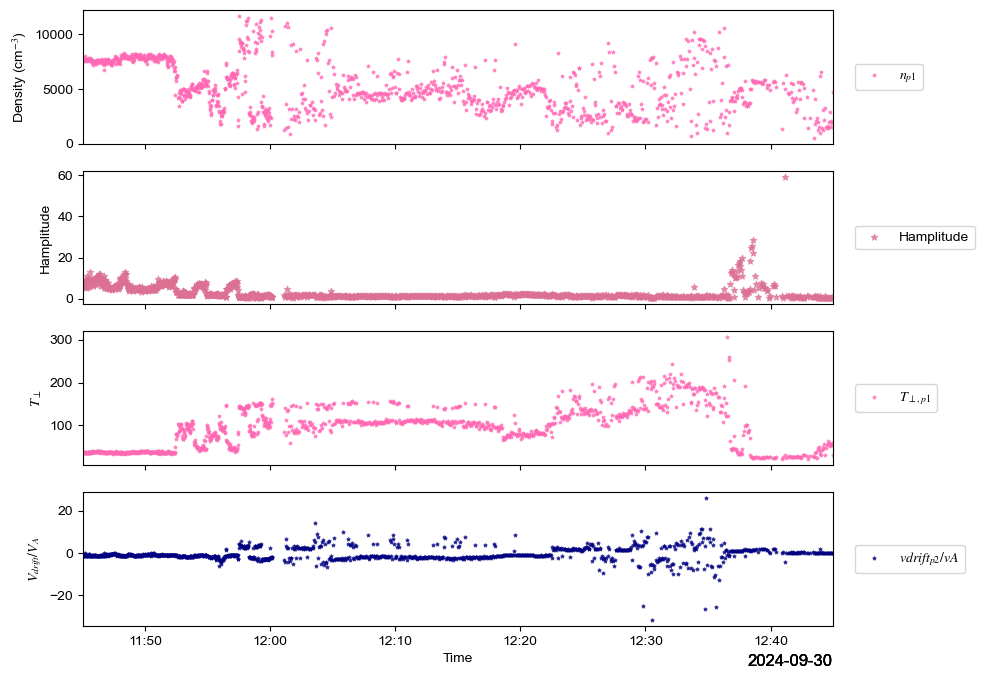

In [23]:
#Example HAM 🍖 and fits plotbot calls!
plt.options.reset() 

print_manager.show_status = True  # Status prints, ⭐️ useful for basic status updates
print_manager.show_debug = False  # Debug prints, helpful for debugging (will print LOTS of lines)

%matplotlib inline 
# %matplotlib widget

# ham_trange = ['2025-03-23 11:00:00.000', '2025-03-23 12:00:00.000']

#server_access.username = 'your_username_here'

# ham.trat_ham.y_limit = [0, 50]

# plotbot(ham_trange, ham.trat_ham, 1)

fits_trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

plotbot(fits_trange, proton_fits.np1, 1, proton_fits.ham_param, 2, proton_fits.Tperp1, 3, proton_fits.vdrift_va_pfits, 4)

## Multiplot

In [24]:
#######-----📈📈📈📈📈 MULTIPLOTTING MAGIC 📉📉📉📉📉📉-----#######

#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
print_manager.show_status = False  # Status prints, useful for status updates

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# RESET PLOTTING OPTIONS (safe practice!)
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

# CONFIGURE Titles, Labels and axes
#====================================================================
plt.options.use_single_title = False
plt.options.use_single_x_axis = True

plt.options.y_label_uses_encounter = False

plt.options.use_custom_x_axis_label = True
plt.options.custom_x_axis_label = 'Relative Time (Hours From Noon)'
plt.options.single_title_text = "PSP FIELDS Mag RTN Around noon for Multiple Days"

# Rainbow Plot 🌈 -- Uncomment the second set for a single color plot!
#====================================================================
# plt.options.color_mode = 'rainbow'  # Options: 'default', 'rainbow', 'single'
plt.options.color_mode = 'default'  # Options: 'default', 'rainbow', 'single'

# CONFIGURE Vertical Line
#====================================================================
plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 1
plt.options.vertical_line_color = 'red'
plt.options.vertical_line_style = '--'

# DATA SELECTION FOR PLOTTING
#====================================================================
plt.options.use_relative_time = True
plt.options.window = '24:00:00.000'
plt.options.position = 'around'  # Position, also try 'before' or 'after'
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 1

# Data Selection
#====================================================================
Ham_Multiplot_dates = [
    # {'noon_time': '2025-03-19/12:00:00.000'},
    {'noon_time': '2025-03-20/12:00:00.000'}, 
    {'noon_time': '2025-03-21/12:00:00.000'},
    {'noon_time': '2025-03-22/12:00:00.000'},
    {'noon_time': '2025-03-23/12:00:00.000'},
    {'noon_time': '2025-03-24/12:00:00.000'},
    {'noon_time': '2025-03-25/12:00:00.000'},
    {'noon_time': '2025-03-26/12:00:00.000'},
    # {'noon_time': '2025-03-27/12:00:00.000'}
]

plot_variable = mag_rtn_4sa.br #You'll need server access to plot this variable!

plot_data = [(encounter['noon_time'], plot_variable) for encounter in Ham_Multiplot_dates]

# Initialize Ham! 🍖 ✨NEW!✨
#====================================================================
plt.options.hamify = True
plt.options.ham_var = ham.hamogram_30s
plt.options.ham_opacity = 0.7

# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
multiplot(plot_data); #You'll need server access to plot this variable! ✨Un-comment to Plot! 

02-Jun-25 21:29:01: Remote index not found: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_4_per_cycle/2025/


KeyboardInterrupt: 

--- Generating Daily Noon Multiplot Series (2025-03-19 to 2025-03-27) ---


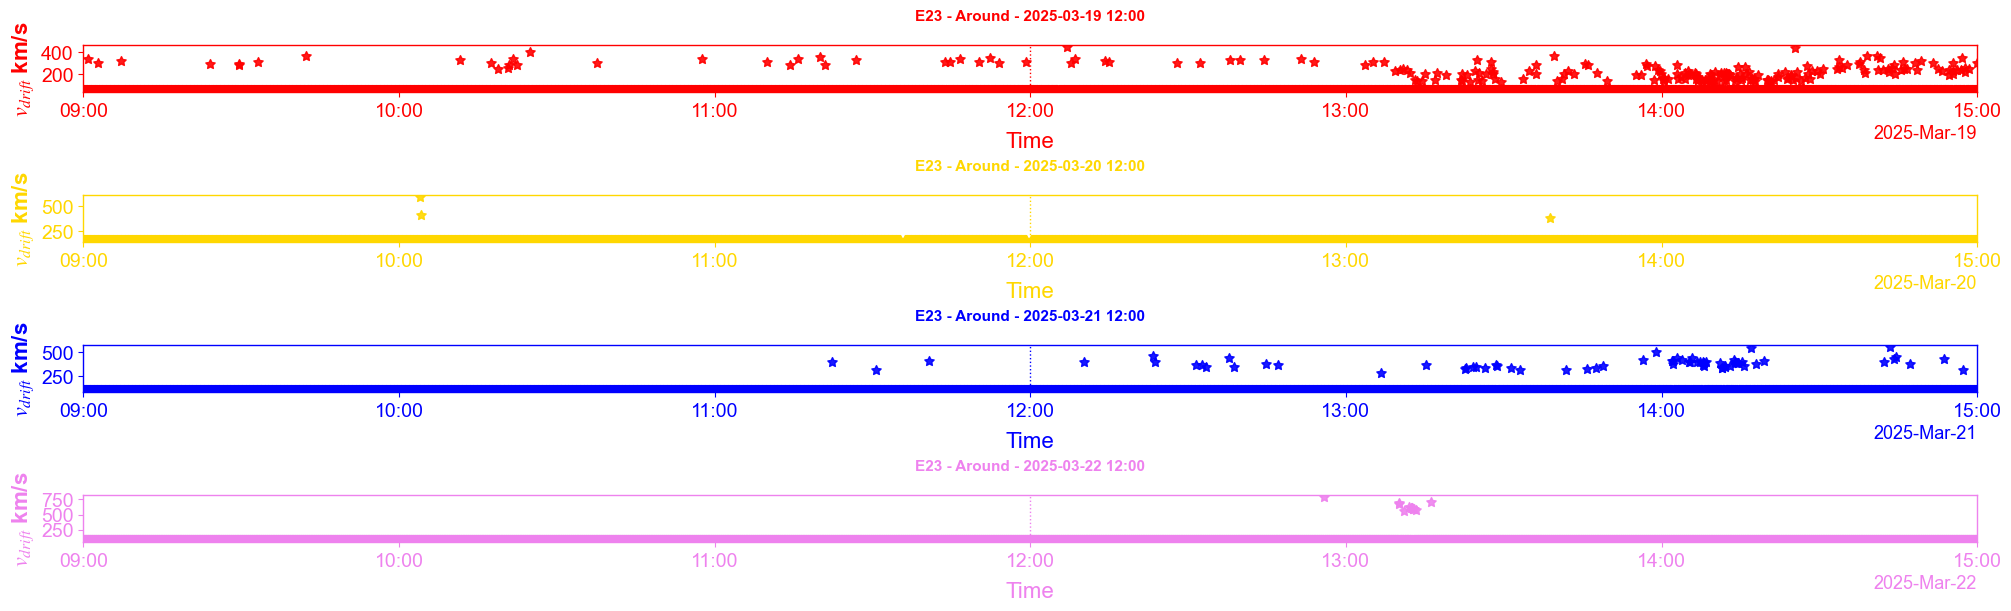

In [ ]:
# Example HAM 🍖 Multiplot Call for Ham/Core Drift Speed across Multiple Days around noon (using all the files you provided)

print_manager.show_status = False  # Status prints, ⭐️ useful for basic status updates

#Use inline for static plots and widget for interactive plots
%matplotlib inline 
# %matplotlib widget

print("--- Generating Daily Noon Multiplot Series (2025-03-19 to 2025-03-27) ---")

# Only use the regular drift speed (not normalized)
ham_drift_vars = [
    ham.ham_core_drift  # Just the drift speed in km/s (not normalized by Alfven speed)
]

# Define ham noon times as a list of dictionaries
ham_noon_times = [
    {'time': '2025-03-19 12:00:00.000'},  # March 19th noon
    {'time': '2025-03-20 12:00:00.000'},  # March 20th noon
    {'time': '2025-03-21 12:00:00.000'},  # March 21st noon
    {'time': '2025-03-22 12:00:00.000'},  # March 22nd noon
    # {'time': '2025-03-23 12:00:00.000'},  # March 23rd noon #Uncomment to see more
    # {'time': '2025-03-24 12:00:00.000'},  # March 24th noon
    # {'time': '2025-03-25 12:00:00.000'},  # March 25th noon
    # {'time': '2025-03-26 12:00:00.000'},  # March 26th noon
    # {'time': '2025-03-27 12:00:00.000'},  # March 27th noon
]

# Create all plot tuples using list comprehension
all_plots = [(day['time'], var) for day in ham_noon_times for var in ham_drift_vars]

# --- Configure Plot Options ---
plt.options.reset() 

# Your existing plot parameters
plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 11
plt.options.y_label_size = 12
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 10
plt.options.y_tick_label_size = 10
plt.options.y_label_pad = 4

plt.options.use_single_title = False
plt.options.y_label_uses_encounter = False
plt.options.y_label_includes_time = False

plt.options.window = '6:00:00'  # +/- 3 hours around noon
plt.options.position = 'around'
plt.options.draw_vertical_line = True

plt.options.color_mode = 'rainbow'
plt.options.single_color = None

plt.options.use_relative_time = False
plt.options.use_single_x_axis = False
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

# Generate the multiplot showing all days
fig, axs = multiplot(all_plots);

--- Generating Daily Noon Multiplot Series (2025-03-19 to 2025-03-27) ---


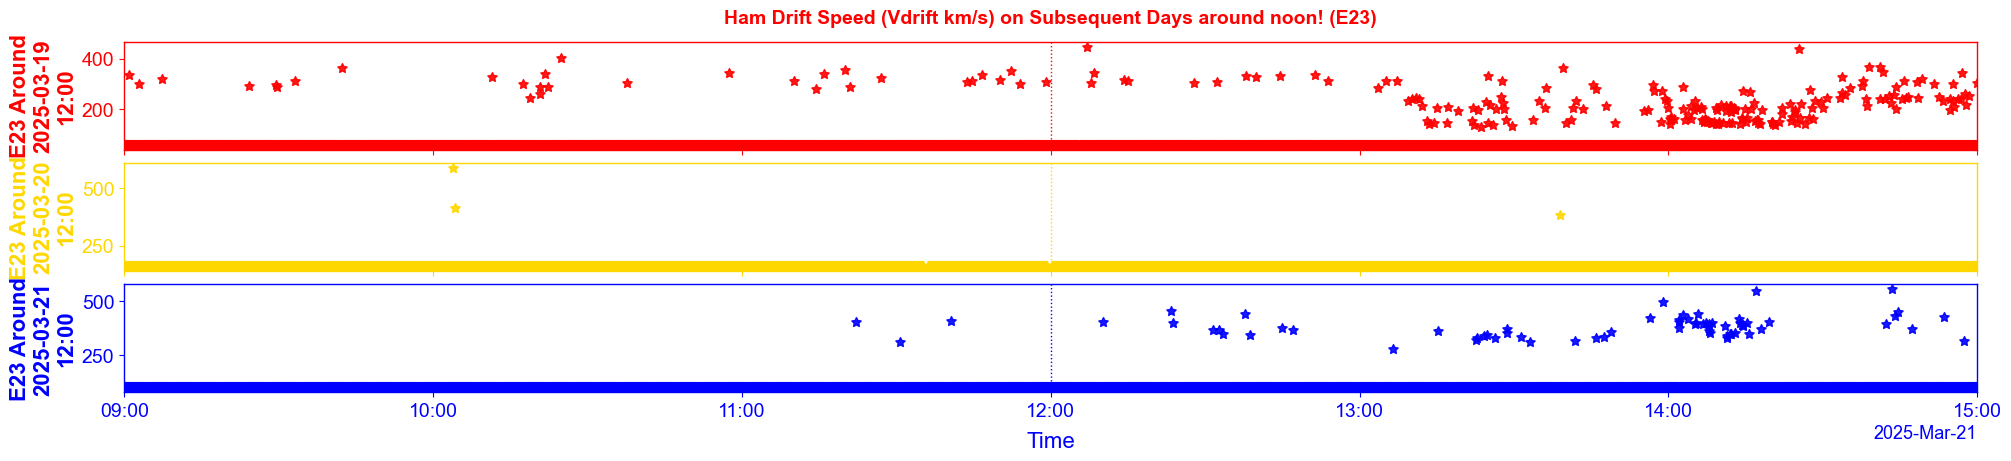

In [ ]:
# REFORMATTED Example HAM 🍖 Multiplot Call for Ham/Core Drift Speed across Multiple Days around noon (using all the files you provided)

print("--- Generating Daily Noon Multiplot Series (2025-03-19 to 2025-03-27) ---")

print_manager.show_status = False# Status prints, ⭐️ useful for basic status updates

#Use inline for static plots and widget for interactive plots
%matplotlib inline 
# %matplotlib widget

# Only use the regular drift speed (not normalized)
ham_drift_vars = [
    ham.ham_core_drift  # Just the drift speed in km/s (not normalized by Alfven speed)
]

# Define ham noon times as a list of dictionaries
ham_noon_times = [
    {'time': '2025-03-19 12:00:00.000'},  # March 19th noon
    {'time': '2025-03-20 12:00:00.000'},  # March 20th noon
    {'time': '2025-03-21 12:00:00.000'},  # March 21st noon
]

# Create all plot tuples using list comprehension
all_plots = [(day['time'], var) for day in ham_noon_times for var in ham_drift_vars]

# --- Configure Plot Options ---
plt.options.reset() 

# Your existing plot parameters
plt.options.width = 20
plt.options.height_per_panel = 1.5
plt.options.hspace = 0.8

# Font Sizes and Padding
plt.options.title_fontsize = 14
plt.options.y_label_size = 12
plt.options.x_label_size = 12
plt.options.x_tick_label_size = 12
plt.options.y_tick_label_size = 12
plt.options.y_label_pad = 4

plt.options.use_single_title = True
plt.options.single_title_text = 'Ham Drift Speed (Vdrift km/s) on Subsequent Days around noon! (E23)'
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = True

plt.options.window = '6:00:00'  # +/- 3 hours around noon
plt.options.position = 'around'
plt.options.draw_vertical_line = True

plt.options.color_mode = 'rainbow'
plt.options.single_color = None

plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'hours'
plt.options.relative_time_step = 1
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = False
plt.options.custom_x_axis_label = None

# Generate the multiplot showing all days
fig, axs = multiplot(all_plots);

### Showdahodo

✨ We can use the showdahodo function to plot two variables against each other, like the radial magnetic field and strahl centroids!



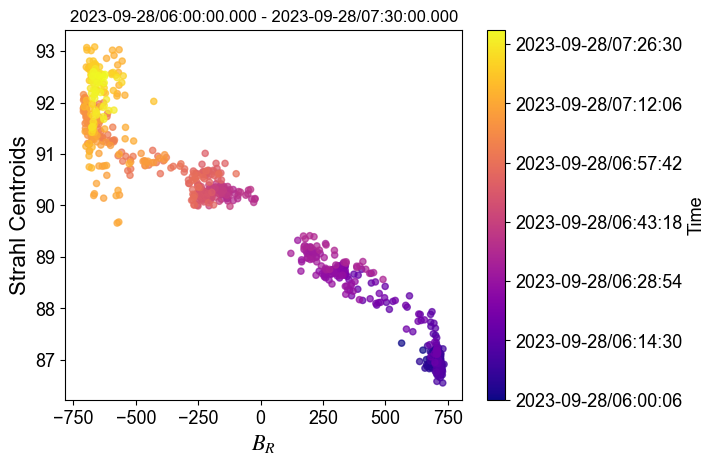

In [ ]:
%matplotlib inline 
# %matplotlib widget

#----Print manager----///
# print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False  # Debug prints, helpful for debugging

#----Showdahodo----///
trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']  # Enc 17 HCS Crossing

print("✨ We can use the showdahodo function to plot two variables against each other, like the radial magnetic field and strahl centroids!\n")

showdahodo(trange, mag_rtn_4sa.br, epad.centroids);

02-Jun-25 21:24:07: /Users/robertalexander/GitHub/Plotbot/plotbot/showdahodo.py:538: RuntimeWarning: invalid value encountered in power
  trat_parfire = 1-(.47/(beta_par - .59)**.53)



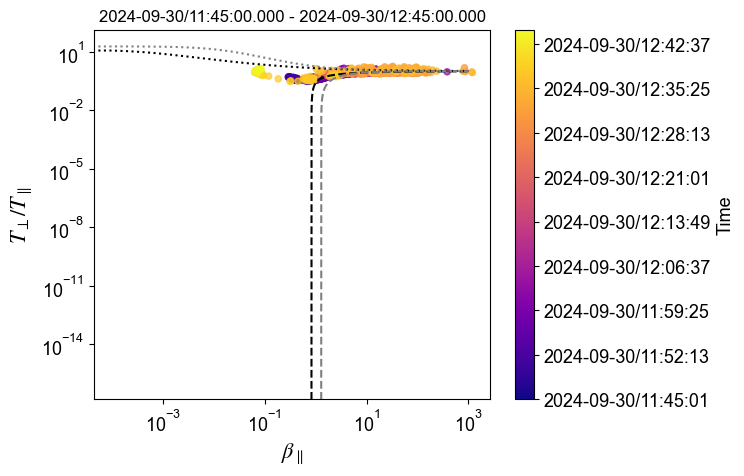

In [ ]:
# First define your time range for September 30, 2024 from 11:45 to 12:45
trange = ['2024-09-30/11:45:00.000', '2024-09-30/12:45:00.000']

proton.beta_ppar.y_scale = 'log'
proton.anisotropy.y_scale = 'log'

# Then use showdahodo with proton.beta_ppar on x-axis and proton.anisotropy on y-axis
showdahodo(trange, proton.beta_ppar, proton.anisotropy, brazil=True);

## Interactive Plotting


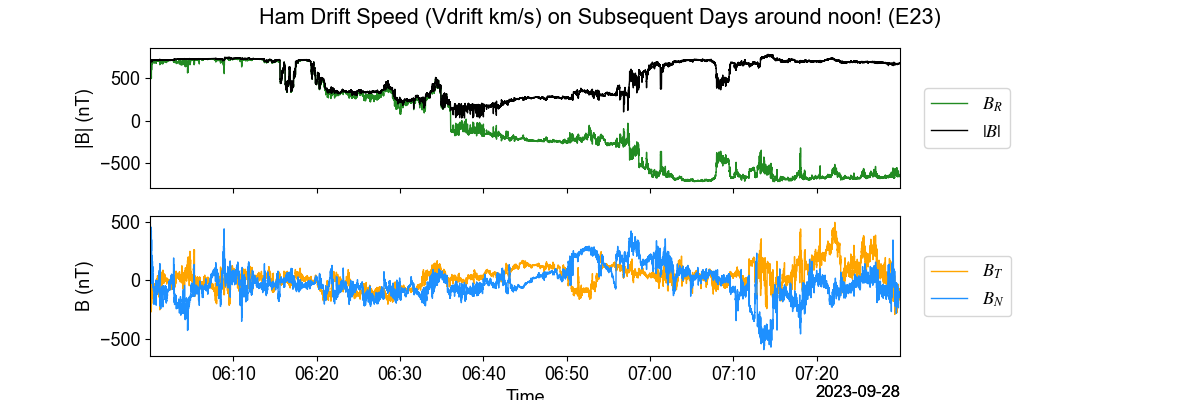

In [ ]:
print_manager.show_status = False # Status prints, ⭐️ useful for basic status updates

#Use inline for static plots and widget for interactive plots
#The panel at the left has options for moving and zooming the plot
# %matplotlib inline 
%matplotlib widget

#E17 HCS Crossing

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

epad.strahl.colorbar_limits = 'default'
epad.strahl.colorbar_scale = 'log'

trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']  # Enc 17 HCS Crossing


plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2)


In [ ]:
#Plot Hodograms with Custom Variables and Showdahodo

print_manager.show_status = False  # Status prints, ⭐️ useful for basic status updates

#Use inline for static plots and widget for interactive plots
%matplotlib inline 
# %matplotlib widget

# Define a time range
trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']
# trange = ['2023-10-28/06:00:00.000', '2023-10-28/07:30:00.000']

# Create a custom variable with our elegant syntax
TAplusBmag = custom_variable('TAplusBmag', proton.anisotropy + mag_rtn_4sa.bmag)

# Then use showdahodo with proton.beta_ppar on x-axis and proton.anisotropy on y-axis
# showdahodo(trange, TAplusBmag, proton.anisotropy, brazil=True);
showdahodo(trange, TAplusBmag, proton.anisotropy);

NameError: name 'data_cubby' is not defined

In [20]:
# #An example with password protected data

# #E21 Glory Region! 
# print_manager.show_status = False  # Status prints, useful for status updates
# print_manager.show_debug = False   # Debug prints, helpful for debugging

# server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

# epad.strahl.colorbar_limits = [10.4, 11]
# epad.strahl.colorbar_scale = 'log'

# trange = ['2024-09-30/12:10:00.000', '2024-09-30/12:20:00.000']
# # plotbot(trange, mag_rtn_4sa.all, 1, mag_rtn_4sa.bmag, 1, 
# #         epad_hr.strahl, 2, 
# #         proton_hr.energy_flux, 3, 
# #         proton_hr.t_perp, 4, 
# #         proton_hr.t_par, 4, proton_hr.anisotropy, '4r', 
# #         proton_hr.v_sw, 5, proton_hr.v_alfven, '5r')

# plotbot(trange, mag_rtn_4sa.br, 1, mag_rtn_4sa.bmag, 1, 
#         mag_rtn_4sa.bt, 2, mag_rtn_4sa.bn, 2, 
#         epad.strahl, 3, 
#         proton.energy_flux, 4, 
#         proton.theta_flux, 5, 
#         proton.phi_flux, 6, 
#         proton.t_perp, 7, 
#         proton.t_par, 7, proton.anisotropy, '7r', 
#         proton.v_sw, 8, proton.v_alfven, 8)

### More Multiplot

In [21]:
#######-----🌈🌈🌈🌈🌈🌈 MULTIPLOTTING Rainbow MAGIC 🌈🌈🌈🌈🌈----#######


%matplotlib inline 

#====================================================================
# DATA SELECTION FOR PLOTTING
#====================================================================
# Define encounter list (assuming rainbow_encounters is defined above this cell)

rainbow_encounters = [ #Add more encounters to see the beauty unfold!
    # {'perihelion': '2018/11/06 03:27:00.000'}, #Enc 1
    # {'perihelion': '2019/04/04 22:39:00.000'}, #Enc 2
    # {'perihelion': '2019/09/01 17:50:00.000'}, #Enc 3
    # {'perihelion': '2020/01/29 09:37:00.000'}, #Enc 4
    # {'perihelion': '2020/06/07 08:23:00.000'}, #Enc 5
    # {'perihelion': '2020/09/27 09:16:00.000'}, #Enc 6
    # {'perihelion': '2021/01/17 17:40:00.000'}, #Enc 7
    # {'perihelion': '2021/04/29 08:48:00.000'}, #Enc 8
    # {'perihelion': '2021/08/09 19:11:00.000'}, #Enc 9
    # {'perihelion': '2021/11/21 08:23:00.000'}, #Enc 10
    # {'perihelion': '2022/02/25 15:38:00.000'}, #Enc 11
    # {'perihelion': '2022/06/01 22:51:00.000'}, #Enc 12
    # {'perihelion': '2022/09/06 06:04:00.000'}, #Enc 13
    {'perihelion': '2022/12/11 13:16:00.000'}, #Enc 14
    {'perihelion': '2023/03/17 20:30:00.000'}, #Enc 15
    {'perihelion': '2023/06/22 03:46:00.000'}, #Enc 16
    # {'perihelion': '2023/09/27 23:28:00.000'}, #Enc 17
    # {'perihelion': '2023/12/29 00:56:00.000'}, #Enc 18
    # {'perihelion': '2024/03/30 02:21:00.000'}, #Enc 19
    # {'perihelion': '2024/06/30 03:47:00.000'}, #Enc 20 Not yet publicly available
    # {'perihelion': '2024/09/30 05:15:00.000'}, #Enc 21 Not yet publicly available
    # {'perihelion': '2024/12/24 11:53:00.000'}, #Enc 22 Not yet publicly available
    # {'perihelion': '2025/03/22 22:42:00.000'}, #Enc 23 Not yet publicly available
]


#====================================================================
# CONFIGURE PRINT MANAGER AND SERVER ACCESS
#====================================================================
print_manager.show_status = True  # Status prints, useful for status updates
# print_manager.show_debug = False  # Debug prints, helpful for debugging

server_access.username = None # Set to None for username prompt, or enter 'your_username' to hardcode.

#====================================================================
# RESET PLOTTING OPTIONS
#====================================================================
plt.options.reset() # Resetting options to ensure a clean slate

#====================================================================
# CONFIGURE GENERAL PLOT OPTIONS (Matching VERTICAL_POSTER_LARGE style)
#====================================================================
# Plot Sizing (These affect the *initial* figure aspect ratio calculation when using output_dimensions)
plt.options.width = 24  # Match aspect ratio (24 inches corresponds to 7200px at 300dpi)
plt.options.height_per_panel = .25 # Less relevant when using output_dimensions for final size

# Margins & Spacing (These are handled by the preset mechanism, less direct mapping here, but hspace is available)
plt.options.hspace = 0.1 # Match preset vertical_space

# Font Sizes and Padding
plt.options.title_fontsize = 24
plt.options.title_pad = 15 # << NEW Option: Adjust title vertical position (default is 6.0)
plt.options.y_label_size = 24
plt.options.x_label_size = 24
plt.options.x_tick_label_size = 18
plt.options.y_tick_label_size = 18
plt.options.y_label_pad = 10
plt.options.x_label_pad = -8 # Negative value pulls label closer to axis

# Title Options
plt.options.use_single_title = True
plt.options.single_title_text = "PSP FIELDS Br Component Around Perihelion for Multiple Encounters"
plt.options.y_label_uses_encounter = True
plt.options.y_label_includes_time = False

# Vertical Line Options
plt.options.draw_vertical_line = True
plt.options.vertical_line_width = 2.0 # From preset line_widths.vertical
plt.options.vertical_line_color = 'red' # Default, not in preset
plt.options.vertical_line_style = '--' # Default, not in preset

# Time Axis Options
plt.options.use_relative_time = True
plt.options.relative_time_step_units = 'days'
plt.options.relative_time_step = 1
plt.options.use_single_x_axis = True
plt.options.use_custom_x_axis_label = True
plt.options.custom_x_axis_label = "Days from Perihelion"

# Border/Spine Width (Note: tick width/length are rcParams, harder to set via options directly)
plt.options.border_line_width = 1.5 # From preset line_widths.spine

#====================================================================
# Rainbow Plot 🌈
#====================================================================
plt.options.color_mode = 'rainbow'
plt.options.single_color = None


plt.options.window = '144:00:00.000'
# plt.options.window = '1:00:00.000'
plt.options.position = 'around'  # Position options for multiplot: 'before', 'after', 'around'
plot_variable = mag_rtn_4sa.br

# Create the plot data list using list comprehension
plot_data = [(encounter['perihelion'], plot_variable) for encounter in rainbow_encounters]

#====================================================================
# CALL MULTIPLOT WITH UPDATED OPTIONS
#====================================================================
# plt.options.save_preset = None # Ensure preset is off
plt.options.save_output = False
plt.options.save_preset = 'VERTICAL_POSTER_LARGE' # Can also use 'VERTICAL_POSTER_MEDIUM' or 'HORIZONTAL_POSTER'
# plt.options.output_dimensions = (7200, 10800) # Set final output size

print("Bring the magic 🌈")
multiplot(plot_data);


Bring the magic 🌈
🛰️ mag_RTN_4sa - acquiring variables: br
☑️ - CDF Data import complete for mag_RTN_4sa range ['2022-12-08/13:16:00.000000', '2022-12-14/13:16:00.000000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ mag_RTN_4sa - acquiring variables: br
☑️ - CDF Data import complete for mag_RTN_4sa range ['2023-03-14/20:30:00.000000', '2023-03-20/20:30:00.000000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

🛰️ mag_RTN_4sa - acquiring variables: br
☑️ - CDF Data import complete for mag_RTN_4sa range ['2023-06-19/03:46:00.000000', '2023-06-25/03:46:00.000000'].

📥 Updating mag_RTN_4sa...
✅ Data acquisition complete

Using constrained_layout=True and letting matplotlib handle all margins and spacing.
Panel 1 - HAM feature status: hamify=False, ham_var=False
Panel 1: Checking HAM plotting conditions: hamify=False, ham_var=False, second_variable_on_right_axis=False
Panel 1: Not plotting HAM data - conditions not met: hamify=False, ham_var=False, second_variable_

## Audification

In [1]:
# To force selection of a new directory:
SET_NEW_SAVE_DIRECTORY = False  # Set to True to choose a new save directory
audifier.select_save_dir(force_new=SET_NEW_SAVE_DIRECTORY)
print()

NameError: name 'audifier' is not defined

In [ ]:
# Optionally change markers per hour from default 120
audifier.markers_per_hour = 60  # 1 marker every 10 seconds = 360 markers per hour,
audifier.markers_only = False  # Default setting
audifier.quantize_markers = True  # hourly
audifier.sample_rate = 22000 # Or try 16000 to slow down playback

audifier.channels = 1

# trange = ['2024-09-27/05:15.000', '2024-10-03/05:15.000']  # Enc 21

# trange = ['2025-03-23/17:30:00.000', '2025-03-23/18:30:00.000']  # Enc 23 Flapping Proof?
trange = ['2025-03-23 17:56:00.000', '2025-03-23 18:06:00.000']  # Enc 23 Flapping Proof Zoom


print(trange)

# Create audio files and markers from any components
# audifier.audify(trange, mag_rtn_4sa.br, mag_rtn_4sa.bt, mag_rtn_4sa.bn, mag_rtn_4sa.bmag)
# plotbot(trange, mag_rtn.br, 1, mag_rtn.bt, 2, mag_rtn.bn, 3, mag_rtn.bmag, 4)
audifier.audify(trange, mag_rtn.br, mag_rtn.bt, mag_rtn.bn, mag_rtn.bmag)


## Math with Plotbot.data

In [ ]:
#Working with Plotbot.data!! (the format is actually "mag_rtn_4sa.bmag.data " but you know what I mean...)

# Statistical Analysis of Magnetic Field Data
print("=== Magnetic Field Data Analysis ===\n")

# Convert plot_manager objects to numpy arrays for analysis
bmag_data = mag_rtn_4sa.bmag.data  
br_data = mag_rtn_4sa.br.data
bt_data = mag_rtn_4sa.bt.data
bn_data = mag_rtn_4sa.bn.data

# Basic checks
print("1. Data Structure Checks:")
print(f"Data type: {type(mag_rtn_4sa.bmag)}")
print(f"Shape: {np.shape(bmag_data)}")
print(f"Number of points: {len(bmag_data)}")
print(f"Memory usage: {bmag_data.nbytes / 1e6:.2f} MB\n")

# Basic statistics
print("2. Basic Statistics:")
print(f"Mean |B|: {np.nanmean(bmag_data):.2f} nT")
print(f"Median |B|: {np.nanmedian(bmag_data):.2f} nT")
print(f"Standard deviation: {np.nanstd(bmag_data):.2f} nT")
print(f"Min |B|: {np.nanmin(bmag_data):.2f} nT")
print(f"Max |B|: {np.nanmax(bmag_data):.2f} nT\n")

# Component analysis
print("3. Component Analysis:")
print("Mean values:")
print(f"⟨Br⟩: {np.nanmean(br_data):.2f} nT")
print(f"⟨Bt⟩: {np.nanmean(bt_data):.2f} nT")
print(f"⟨Bn⟩: {np.nanmean(bn_data):.2f} nT\n")

# Calculate field angles
theta = np.arctan2(np.sqrt(bt_data**2 + bn_data**2), br_data)
phi = np.arctan2(bn_data, bt_data)

print("4. Field Orientation:")
print(f"Mean θ (from radial): {np.degrees(np.nanmean(theta)):.2f}°")
print(f"Mean φ (azimuthal): {np.degrees(np.nanmean(phi)):.2f}°\n")

# Power and energy density
mu0 = 4 * np.pi * 1e-7  # permeability of free space
B_squared = bmag_data**2
energy_density = B_squared / (2 * mu0) * 1e-9  # Convert to J/m^3

print("5. Energy Analysis:")
print(f"Mean B²: {np.nanmean(B_squared):.2f} nT²")
print(f"Mean magnetic energy density: {np.nanmean(energy_density):.2e} J/m³\n")

# Time series analysis
if hasattr(mag_rtn_4sa, 'datetime_array'):
    print("6. Time Series Properties:")
    # Convert datetime array to numeric values for time difference calculation
    time_array = np.array(mag_rtn_4sa.datetime_array, dtype='datetime64[ns]')
    time_diffs = np.diff(time_array)
    mean_cadence_ns = np.mean(time_diffs)
    mean_cadence_s = mean_cadence_ns / np.timedelta64(1, 's')  # Convert to seconds
    print(f"Mean sampling cadence: {mean_cadence_s:.6f} seconds")
    
    # Calculate power spectrum using sampling frequency in Hz
    from scipy import signal
    fs = 1.0 / mean_cadence_s
    # Remove NaN values for spectrum calculation
    valid_data = bmag_data[~np.isnan(bmag_data)]
    if len(valid_data) > 0:
        f, Pxx = signal.welch(valid_data - np.mean(valid_data), fs=fs)
        peak_freq = f[np.argmax(Pxx)]
        print(f"Dominant frequency in power spectrum: {peak_freq:.2e} Hz\n")

# Data quality checks
print("7. Data Quality Metrics:")
print(f"Number of NaN values: {np.sum(np.isnan(bmag_data))}")
print(f"Number of zeros: {np.sum(bmag_data == 0)}")
print(f"Number of values > 3σ: {np.sum(np.abs(bmag_data - np.nanmean(bmag_data)) > 3*np.nanstd(bmag_data))}\n")

# Visualization
plt.figure(figsize=(12, 8))

# Plot 1: Histogram of |B|
plt.subplot(221)
plt.hist(bmag_data[~np.isnan(bmag_data)], bins=50, density=True)
plt.title('|B| Distribution')
plt.xlabel('|B| (nT)')
plt.ylabel('Density')

# Plot 2: Component correlations
plt.subplot(222)
mask = ~np.isnan(br_data) & ~np.isnan(bt_data)
plt.scatter(br_data[mask], bt_data[mask], alpha=0.1)
plt.xlabel('Br (nT)')
plt.ylabel('Bt (nT)')
plt.title('Br vs Bt')

# Plot 3: Field angle distribution
plt.subplot(223)
mask = ~np.isnan(theta) & ~np.isnan(phi)
plt.hist2d(np.degrees(theta[mask]), np.degrees(phi[mask]), bins=50)
plt.xlabel('θ (degrees)')
plt.ylabel('φ (degrees)')
plt.title('Field Angle Distribution')
plt.colorbar()

# Plot 4: Power spectrum
plt.subplot(224)
if hasattr(mag_rtn_4sa, 'datetime_array'):
    valid_data = bmag_data[~np.isnan(bmag_data)]
    if len(valid_data) > 0:
        plt.loglog(f, Pxx)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.title('Power Spectrum')

plt.tight_layout()
plt.show()

## Custom Variables - COMING SOON

In [ ]:
# #COMING SOON#

# #We can create custom variables using the syntax below:
# pb.plt.options.reset()
# print_manager.show_status = False  # Status prints, ⭐️ useful for basic status updates

# # Define a time range
# trange = ['2023-09-28/06:00:00.000', '2023-09-28/07:30:00.000']

# # Create a custom variable with our elegant syntax
# TAplusBmag = custom_variable('TAplusBmag', proton.anisotropy + mag_rtn_4sa.bmag)

# # The variable is now globally accessible as TAoverBmag

# # Customize the appearance of the custom variable
# TAplusBmag.color = 'red'
# TAplusBmag.line_style = '-'
# TAplusBmag.line_width = 1
# TAplusBmag.legend_label = 'Custom Label'

# plotbot(trange, mag_rtn_4sa.bmag, 1, TAplusBmag, 2)